In [1]:
import pandas as pd
from sklearn import feature_selection, metrics, linear_model
import sklearn
import matplotlib.pyplot as plt
import xgboost as xgb

/var/folders/qy/d4gqcbtd3mb8ywz_m0qm7g440000gn/T/ipykernel_25836/1893996908.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [14]:
K562_enh_df = pd.read_csv("K562_crispri/enh_feature.tsv", sep="\t").filter(regex=("chrom|start|end|RPKM"), axis=1)
K562_pro_df = pd.read_csv("K562_crispri/pro_feature.tsv", sep="\t").filter(regex=("chrom|start|end|RPKM"), axis=1)
K562_ABC_rep_df = pd.read_csv("K562_crispri/EPCrisprBenchmark_ensemble_data_GRCh38.K562_ActivityOnly_features_NAfilled.tsv", sep="\t")
K562_ENFORMER_df = pd.read_csv("K562_crispri/ENFORMER_output_0.tsv", sep="\t", index_col=0)

In [37]:
K562_all_df = pd.concat([K562_ABC_rep_df[['dataset', 'chrom', 'chromStart', 'chromEnd', 'name', 'chrTSS', 'startTSS', 'endTSS', 'ABC.Score', 'distanceToTSS', 'Regulated']],
                    K562_enh_df.drop(["chrom", "start", "end"], axis=1).rename(lambda x: "enh_"+x, axis=1).apply(lambda x: (x-x.mean())/x.std(), axis=0), 
                    K562_pro_df.drop(["chrom", "start", "end"], axis=1).rename(lambda x: "pro_"+x, axis=1).apply(lambda x: (x-x.mean())/x.std(), axis=0),
                    ], axis = 1)
K562_all_df = K562_all_df.merge(K562_ENFORMER_df[["name", "ENFORMER_score"]], on="name", how="left")
K562_all_df = K562_all_df[
    ['dataset', 'chrom', 'chromStart', 'chromEnd', 'name', 'chrTSS',
       'startTSS', 'endTSS', 'enh_DNase.counts.RPKM',
       'enh_H3K4me3.counts.RPKM', 'enh_CTCF.counts.RPKM',
       'enh_H3K27ac.counts.RPKM', 'enh_CAGE.counts.RPKM',
       'pro_DNase.counts.RPKM', 'pro_H3K4me3.counts.RPKM',
       'pro_CTCF.counts.RPKM', 'pro_H3K27ac.counts.RPKM',
       'pro_CAGE.counts.RPKM', 'ABC.Score', 'ENFORMER_score', 'distanceToTSS', 'Regulated',
    ]
]

In [39]:
K562_all_df["ENFORMER_score"] = K562_all_df["ENFORMER_score"].fillna(0)
K562_all_df.isna().any()

dataset                    False
chrom                      False
chromStart                 False
chromEnd                   False
name                       False
chrTSS                     False
startTSS                   False
endTSS                     False
enh_DNase.counts.RPKM      False
enh_H3K4me3.counts.RPKM    False
enh_CTCF.counts.RPKM       False
enh_H3K27ac.counts.RPKM    False
enh_CAGE.counts.RPKM       False
pro_DNase.counts.RPKM      False
pro_H3K4me3.counts.RPKM    False
pro_CTCF.counts.RPKM       False
pro_H3K27ac.counts.RPKM    False
pro_CAGE.counts.RPKM       False
ABC.Score                  False
ENFORMER_score             False
distanceToTSS              False
Regulated                  False
dtype: bool

In [55]:
LNCaP_enh_df = pd.read_csv("LNCaP_PCHi_C/enh_feature.tsv", sep="\t").filter(regex=("chrom|start|end|RPKM"), axis=1)
LNCaP_pro_df = pd.read_csv("LNCaP_PCHi_C/pro_feature.tsv", sep="\t").filter(regex=("chrom|start|end|RPKM"), axis=1)
LNCaP_ABC_rep_df = pd.read_csv("LNCaP_PCHi_C/ABC_annotated_candidate_pairs.tsv", sep="\t")

LNCaP_all_df = pd.concat([LNCaP_ABC_rep_df[['chr', 'start', 'end', 'chrTSS', 'startTSS', 'endTSS', 'ABC.Score', 'distanceToTSS', 'PCHi-C_Score', 'Label']],
                    LNCaP_enh_df.drop(["chrom", "start", "end"], axis=1).rename(lambda x: "enh_"+x, axis=1).apply(lambda x: (x-x.mean())/x.std(), axis=0), 
                    LNCaP_pro_df.drop(["chrom", "start", "end"], axis=1).rename(lambda x: "pro_"+x, axis=1).apply(lambda x: (x-x.mean())/x.std(), axis=0),
                    ], axis = 1)
LNCaP_all_df = LNCaP_all_df[
    ['chr', 'start', 'end', 'chrTSS',
       'startTSS', 'endTSS', 'enh_DNase.counts.RPKM',
       'enh_H3K4me3.counts.RPKM', 'enh_CTCF.counts.RPKM',
       'enh_H3K27ac.counts.RPKM', 'pro_DNase.counts.RPKM', 'pro_H3K4me3.counts.RPKM',
       'pro_CTCF.counts.RPKM', 'pro_H3K27ac.counts.RPKM', 'ABC.Score', 'distanceToTSS', 'PCHi-C_Score', 'Label',
    ]
]

# Graph 1: Mutual Information (all features)

In [40]:
feature_columns = K562_all_df.columns[8:-1]
label_column = K562_all_df.columns[-1]

print(feature_columns)

feature_MI = feature_selection.mutual_info_classif(K562_all_df[feature_columns], K562_all_df[label_column])

MI_results = list(zip(feature_columns, feature_MI))
MI_results.sort(key = lambda x: x[1], reverse=True)
print(MI_results)

Index(['enh_DNase.counts.RPKM', 'enh_H3K4me3.counts.RPKM',
       'enh_CTCF.counts.RPKM', 'enh_H3K27ac.counts.RPKM',
       'enh_CAGE.counts.RPKM', 'pro_DNase.counts.RPKM',
       'pro_H3K4me3.counts.RPKM', 'pro_CTCF.counts.RPKM',
       'pro_H3K27ac.counts.RPKM', 'pro_CAGE.counts.RPKM', 'ABC.Score',
       'ENFORMER_score', 'distanceToTSS'],
      dtype='object')
[('ABC.Score', 0.08819894489483215), ('distanceToTSS', 0.0657375143214991), ('ENFORMER_score', 0.05779235076341549), ('enh_H3K27ac.counts.RPKM', 0.027062342229517533), ('enh_DNase.counts.RPKM', 0.026910929137281103), ('pro_H3K4me3.counts.RPKM', 0.021852353885419618), ('pro_DNase.counts.RPKM', 0.019955464517511512), ('pro_CAGE.counts.RPKM', 0.01870243485236789), ('pro_H3K27ac.counts.RPKM', 0.01841363794108397), ('enh_CTCF.counts.RPKM', 0.013391559422525345), ('pro_CTCF.counts.RPKM', 0.010382766591144676), ('enh_H3K4me3.counts.RPKM', 0.010263770508071701), ('enh_CAGE.counts.RPKM', 0.003965325123631791)]


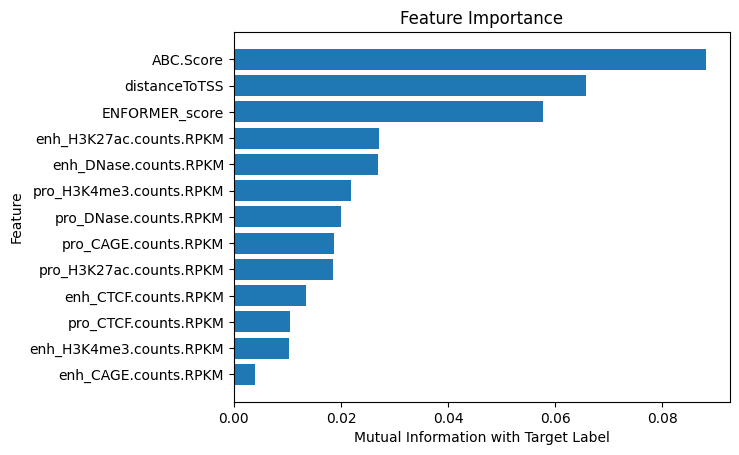

In [41]:
feature_columns, feature_MI = zip(*MI_results)
plt.title("Feature Importance")
plt.ylabel("Feature")
plt.xlabel("Mutual Information with Target Label")
plt.barh(feature_columns, feature_MI)
plt.gca().invert_yaxis()  # labels read top-to-bottom
plt.show()

# Graph 2: auPRC curves

In [42]:
def run_xgboost(feature_columns, chrom_test_set, all_df, print_auprc=True, plot_auprc=True, plot_xgb_feat_importance=True):
    X_train = all_df[~all_df["chrom"].isin(chrom_test_set)][feature_columns]
    y_train = all_df[~all_df["chrom"].isin(chrom_test_set)]["Regulated"]
    X_test = all_df[all_df["chrom"].isin(chrom_test_set)][feature_columns]
    y_test = all_df[all_df["chrom"].isin(chrom_test_set)]["Regulated"]

    clf = xgb.XGBClassifier()
    clf.fit(X_train, y_train)

    precision, recall, thresholds = metrics.precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
    aupr = metrics.auc(recall, precision)

    if print_auprc:
        print("AUPRC:", aupr)

    if plot_auprc:
        plt.title("Precision Recall Curve")
        plt.plot(recall, precision)
        plt.show()

    if plot_xgb_feat_importance:
        xgb.plot_importance(clf) # F score is simply the number of times the classifier split on a particular feature. 
        plt.show()
    
    return aupr, precision, recall

In [43]:
import itertools
import numpy as np

def janky_bootstrap(feature_columns, all_df, chromosomes, r=2):
    aupr_list = []
    chr_test_sets = itertools.combinations(chromosomes, r)
    n = 0
    for chr_set in chr_test_sets:
        n += 1
        aupr, _, _ = run_xgboost(feature_columns, chr_set, all_df, False, False, False)
        aupr_list.append(aupr)
    
    return np.mean(aupr_list), np.std(aupr_list) / np.sqrt(n)



In [44]:
chrom_test_set = ["chr1", "chr11"]
aupr_dict = dict([])

all_feature_columns = ['enh_DNase.counts.RPKM', 'enh_H3K4me3.counts.RPKM',
       'enh_CTCF.counts.RPKM', 'enh_H3K27ac.counts.RPKM',
       'enh_CAGE.counts.RPKM', 'pro_DNase.counts.RPKM',
       'pro_H3K4me3.counts.RPKM', 'pro_CTCF.counts.RPKM',
       'pro_H3K27ac.counts.RPKM', 'pro_CAGE.counts.RPKM', 'ABC.Score',
       'ENFORMER_score', 'distanceToTSS']

aupr, precision, recall = run_xgboost(all_feature_columns, chrom_test_set, K562_all_df, False, False, False)
aupr_dict["All"] = (aupr, precision, recall)

In [45]:
ABC_plus_feature_columns = ["ABC.Score", "distanceToTSS", "enh_DNase.counts.RPKM", "enh_H3K27ac.counts.RPKM", "pro_H3K27ac.counts.RPKM", "pro_DNase.counts.RPKM", "ENFORMER_score"]

aupr, precision, recall = run_xgboost(ABC_plus_feature_columns, chrom_test_set, K562_all_df, plot_auprc=False, plot_xgb_feat_importance=False)
aupr_dict["ABC+"] = (aupr, precision, recall)

AUPRC: 0.6993673499563666


In [27]:
ABC_feature_columns = ['ABC.Score']

aupr, precision, recall = run_xgboost(ABC_feature_columns, chrom_test_set, K562_all_df, plot_auprc=False, plot_xgb_feat_importance=False)
aupr_dict["ABC Only"] = (aupr, precision, recall)


AUPRC: 0.5873036383864056


In [28]:
distance_feature_columns = ['distanceToTSS']

aupr, precision, recall = run_xgboost(distance_feature_columns, chrom_test_set, K562_all_df, plot_auprc=False, plot_xgb_feat_importance=False)
aupr_dict["Distance Only"] = (aupr, precision, recall)


AUPRC: 0.512236923012344


In [29]:
ENFORMER_feature_columns = ['ENFORMER_score']

aupr, precision, recall = run_xgboost(ENFORMER_feature_columns, chrom_test_set, K562_all_df, plot_auprc=False, plot_xgb_feat_importance=False)
aupr_dict["ENFORMER Only"] = (aupr, precision, recall)


AUPRC: 0.4431662891908927


In [30]:
epigenome_feature_columns = ['enh_DNase.counts.RPKM', 'enh_H3K4me3.counts.RPKM',
       'enh_CTCF.counts.RPKM', 'enh_H3K27ac.counts.RPKM',
       'enh_CAGE.counts.RPKM', 'pro_DNase.counts.RPKM',
       'pro_H3K4me3.counts.RPKM', 'pro_CTCF.counts.RPKM',
       'pro_H3K27ac.counts.RPKM', 'pro_CAGE.counts.RPKM']

aupr, precision, recall = run_xgboost(epigenome_feature_columns, chrom_test_set, K562_all_df, plot_auprc=False, plot_xgb_feat_importance=False)
aupr_dict["Epigenome Only"] = (aupr, precision, recall)


AUPRC: 0.19579924530208587


In [32]:
bootstrap_result = dict([])
print("All")
bootstrap_result["All"] = janky_bootstrap(all_feature_columns, K562_all_df, K562_all_df["chrom"].unique())
print("ABC+")
bootstrap_result["ABC+"] = janky_bootstrap(ABC_plus_feature_columns, K562_all_df, K562_all_df["chrom"].unique())
print("ABC only")
bootstrap_result["ABC only"] = janky_bootstrap(ABC_feature_columns, K562_all_df, K562_all_df["chrom"].unique())
print("Distance only")
bootstrap_result["Distance only"] = janky_bootstrap(distance_feature_columns, K562_all_df, K562_all_df["chrom"].unique())
print("ENFORMER only")
bootstrap_result["ENFORMER only"] = janky_bootstrap(ENFORMER_feature_columns, K562_all_df, K562_all_df["chrom"].unique())
print("Epigenome only")
bootstrap_result["Epigenome only"] = janky_bootstrap(epigenome_feature_columns, K562_all_df, K562_all_df["chrom"].unique())



All
ABC+
ABC only
Distance only
ENFORMER only
Epigenome only


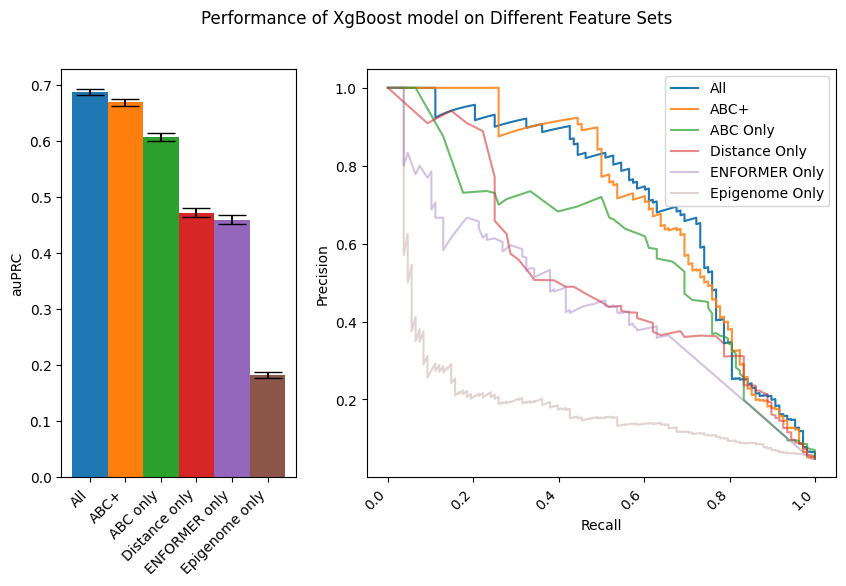

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [1, 2]})
plt.suptitle("Performance of XgBoost model on Different Feature Sets")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
a = 1

for k, v in aupr_dict.items():
    ax[1].plot(v[2], v[1], label=k, alpha=a)
    a -= 0.15
ax[1].legend(loc="upper right")

ax[0].bar(bootstrap_result.keys(), [v[0] for _, v in bootstrap_result.items()], yerr=[v[1] for _, v in bootstrap_result.items()] , width=1.0, color=["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"], ecolor='black', capsize=10)
fig.autofmt_xdate(rotation=45)
ax[0].set_ylabel("auPRC")



plt.show()


# Graph 3: PCHi-C vs ABC

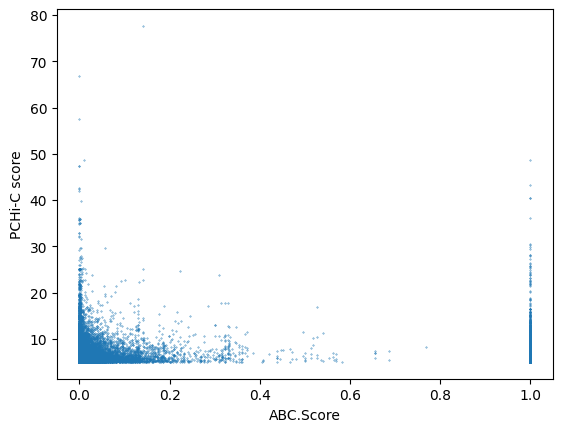

In [59]:
plt.scatter("ABC.Score", "PCHi-C_Score", data=LNCaP_all_df[LNCaP_all_df["Label"]], s=0.1)
plt.xlabel("ABC.Score")
plt.ylabel("PCHi-C score")
plt.show()

# Graph 4: ABC Score between groups 

In [62]:
import scipy.stats as st
ABC_groupby = LNCaP_all_df.groupby(by="Label")["ABC.Score"].agg(["mean", "std", "count"])
ABC_groupby

,mean,std,count
Label,,,
False,0.00954,0.081137,128003
True,0.11433,0.298186,34160


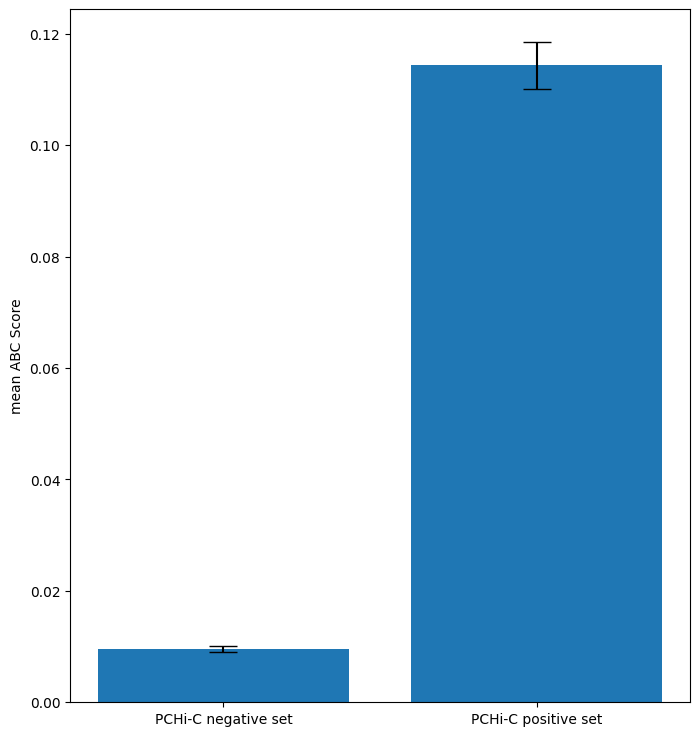

In [67]:
fig, ax = plt.subplots(figsize=(8,9))
plt.bar(["PCHi-C negative set", "PCHi-C positive set"], ABC_groupby["mean"], yerr=[x["std"]*st.norm.interval(0.99)[1]/np.sqrt(x["count"]) for _, x in ABC_groupby.iterrows()], ecolor='black', capsize=10)
plt.ylabel("mean ABC Score")
plt.show()

# Graph 5: model generalisability

In [68]:
feature_columns = ['enh_DNase.counts.RPKM', 'enh_H3K4me3.counts.RPKM',
       'enh_CTCF.counts.RPKM', 'enh_H3K27ac.counts.RPKM', 'pro_DNase.counts.RPKM',
       'pro_H3K4me3.counts.RPKM', 'pro_CTCF.counts.RPKM',
       'pro_H3K27ac.counts.RPKM', 'ABC.Score',
       'distanceToTSS']

X_train = K562_all_df[feature_columns]
y_train = K562_all_df["Regulated"]

clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

AUPRC: 0.5289971450263138


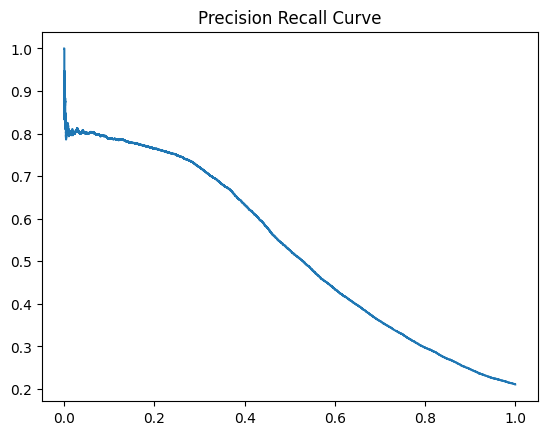

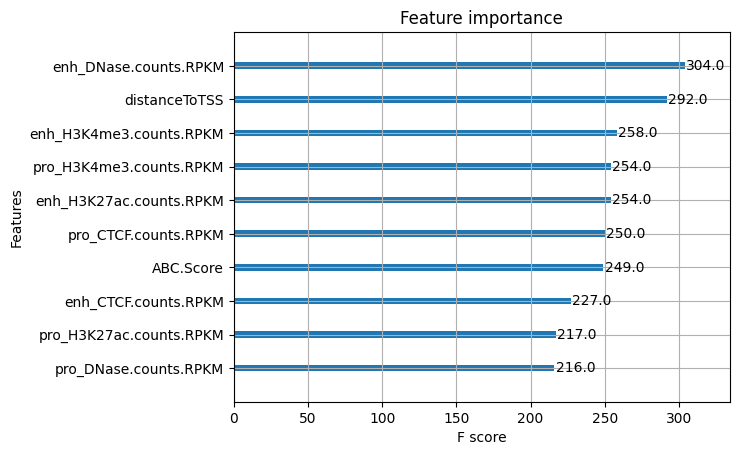

In [69]:
feature_columns = ['enh_DNase.counts.RPKM', 'enh_H3K4me3.counts.RPKM',
       'enh_CTCF.counts.RPKM', 'enh_H3K27ac.counts.RPKM', 'pro_DNase.counts.RPKM',
       'pro_H3K4me3.counts.RPKM', 'pro_CTCF.counts.RPKM',
       'pro_H3K27ac.counts.RPKM', 'ABC.Score',
       'distanceToTSS']

X_test = LNCaP_all_df[feature_columns]
y_test = LNCaP_all_df["Label"]

precision, recall, thresholds = metrics.precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
aupr = metrics.auc(recall, precision)

print("AUPRC:", aupr)

plt.title("Precision Recall Curve")
plt.plot(recall, precision)
plt.show()


xgb.plot_importance(clf) # F score is simply the number of times the classifier split on a particular feature. 
plt.show()